In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import seaborn as sns
from tqdm import tqdm
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from keras.models import Model
import math

import config

In [21]:
def plot_confusion_matrix(model, ds, label_names):
    y_pred = []
    y_true = []
    for batch in ds.as_numpy_iterator():
        imgs, labels = batch
        out = model.predict(imgs)
        for i in range(len(labels)):
            y_pred.append(np.argmax(out[i]))
            y_true.append(np.argmax(labels[i]))
    cm = confusion_matrix(y_true, y_pred)
    cm = cm / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, xticklabels=label_names, yticklabels=label_names, cmap='Oranges', cbar=False)

# plot history of training
def plot_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history['categorical_accuracy'], label='accuracy')
    plt.plot(history['val_categorical_accuracy'], label='val_accuracy')
    plt.ylim([0, 1])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.figure(figsize=(10, 5))
    plt.plot(history['loss'], label='loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

In [30]:
# Load the data
train_ds , _, eval_ds = config.get_datasets()

Found 3764 files belonging to 7 classes.


Model loading

In [4]:
model = keras.Sequential()
model.add(keras.Input(shape=(config.image_size[0], config.image_size[1], 1)))

# Preprocessing
model.add(keras.layers.RandomTranslation(0.1, 0.1))
model.add(keras.layers.RandomBrightness(0.1))
model.add(keras.layers.RandomContrast(0.1))

# Rescale the pixel values
model.add(keras.layers.Rescaling(1./255))

# Convolutional layers
model.add(keras.layers.Conv2D(16,3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Conv2D(32,3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Conv2D(64,3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Flatten())

# Dense Layers
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(config.n_classes, activation='softmax'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
                     loss='categorical_crossentropy', 
                     metrics=[keras.metrics.CategoricalAccuracy(),
                              keras.metrics.AUC(),
                              keras.metrics.F1Score(), 
                              keras.metrics.Precision(),
                              keras.metrics.Recall()])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_translation              │ (None, 128, 128, 1)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness               │ (None, 128, 128, 1)    │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 128, 128, 1)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,121,479 (8.09 MB)

 Trainable params: 2,121,479 (8.09 MB)

 Non-trainable params: 0 (0.00 B)

/Users/mariapolak/miniconda3/envs/mlme/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 21 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - auc: 0.8618 - categorical_accuracy: 0.5550 - f1_score: 0.5389 - loss: 1.3664 - precision: 0.6116 - recall: 0.4298
Test Loss: 1.448562741279602
Test Accuracy: 0.5222772359848022
Test AUC: 0.8466459512710571
Test F1 Score: [0.45652166 0.5981308  0.42857137 0.67948717 0.41935477 0.50909084
 0.48888883]
Test Precision: 0.5839415788650513
Test Recall: 0.39603960514068604
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-12-03 12:58:49.398506: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


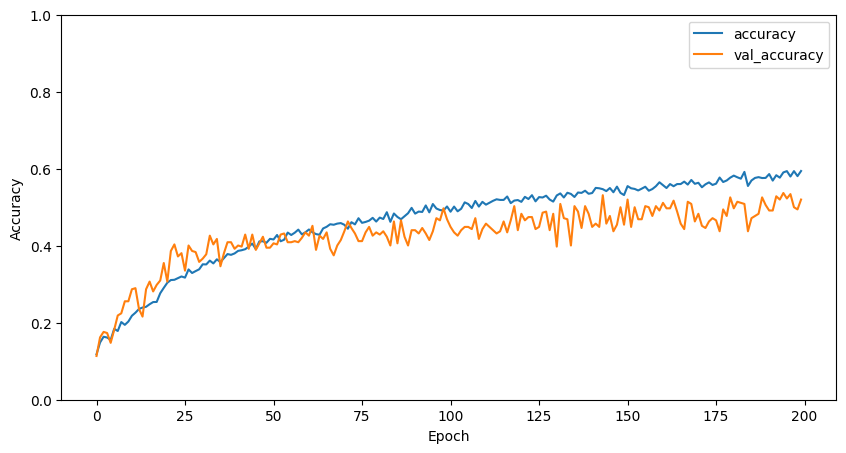

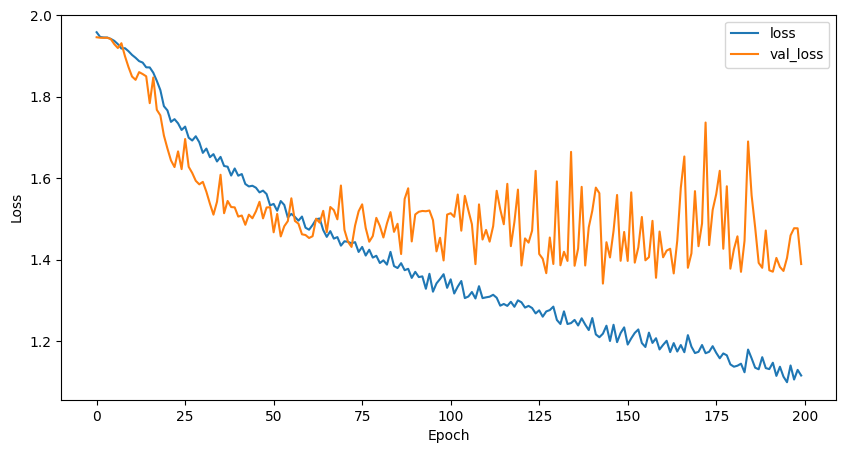

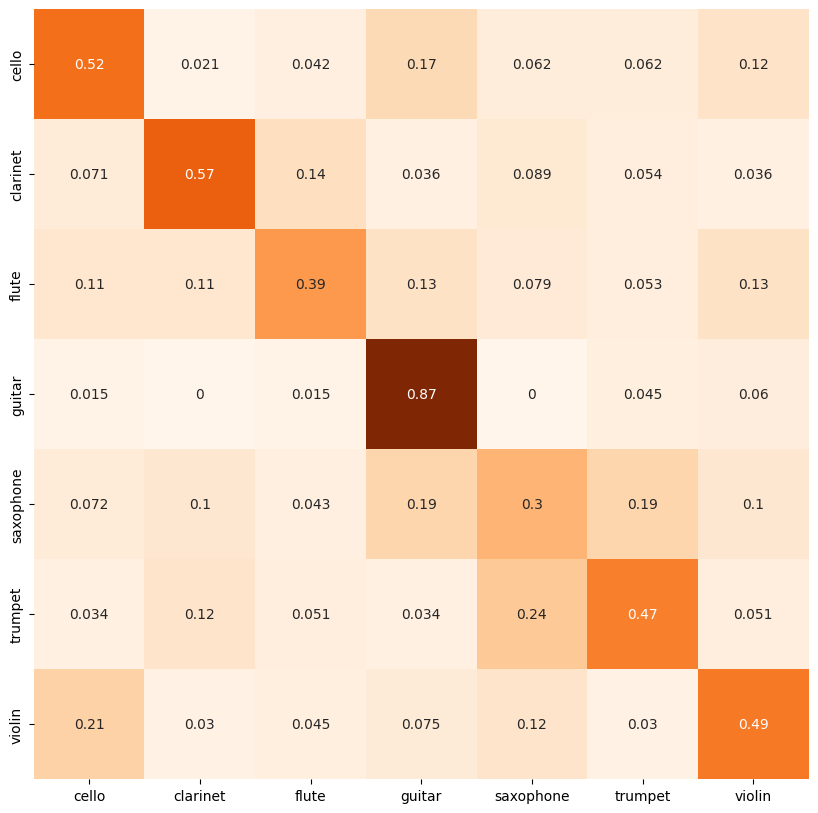

In [22]:
model.load_weights("results/adam-1e3-conv1/instrument-recognition.weights.h5")
history=np.load('results/adam-1e3-conv1/history.npy',allow_pickle='TRUE').item()
plot_history(history)
results = model.evaluate(eval_ds)

print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")
print(f"Test AUC: {results[2]}")
print(f"Test F1 Score: {results[3]}")
print(f"Test Precision: {results[4]}")
print(f"Test Recall: {results[5]}")

plot_confusion_matrix(model, eval_ds, config.label_names)

In [6]:
model2 = keras.Sequential()
model2.add(keras.Input(shape=(config.image_size[0], config.image_size[1], 1)))

# Preprocessing
model2.add(keras.layers.RandomTranslation(0.1, 0.1))
model2.add(keras.layers.RandomBrightness(0.1))
model2.add(keras.layers.RandomContrast(0.1))

# Rescale the pixel values
model2.add(keras.layers.Rescaling(1./255))

# Convolutional layers
model2.add(keras.layers.Conv2D(16,3, padding='same', activation='relu'))
model2.add(keras.layers.Conv2D(16,3, padding='same', activation='relu'))
model2.add(keras.layers.MaxPooling2D())
model2.add(keras.layers.Conv2D(32,3, padding='same', activation='relu'))
model2.add(keras.layers.Conv2D(32,3, padding='same', activation='relu'))
model2.add(keras.layers.MaxPooling2D())
model2.add(keras.layers.Conv2D(64,3, padding='same', activation='relu'))
model2.add(keras.layers.Conv2D(64,3, padding='same', activation='relu'))
model2.add(keras.layers.MaxPooling2D())
model2.add(keras.layers.Dropout(0.2))
model2.add(keras.layers.Flatten())

# Dense Layers
model2.add(keras.layers.Dense(128, activation='relu'))
model2.add(keras.layers.Dense(config.n_classes, activation='softmax'))

model2.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
                     loss='categorical_crossentropy', 
                     metrics=[keras.metrics.CategoricalAccuracy(),
                              keras.metrics.AUC(),
                              keras.metrics.F1Score(), 
                              keras.metrics.Precision(),
                              keras.metrics.Recall()])

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_translation_1            │ (None, 128, 128, 1)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness_1             │ (None, 128, 128, 1)    │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_1               │ (None, 128, 128, 1)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,169,975 (8.28 MB)

 Trainable params: 2,169,975 (8.28 MB)

 Non-trainable params: 0 (0.00 B)

/Users/mariapolak/miniconda3/envs/mlme/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 33 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - auc_1: 0.5000 - categorical_accuracy: 0.1318 - f1_score: 0.0332 - loss: 1.9459 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Test Loss: 1.9460238218307495
Test Accuracy: 0.12376237660646439
Test AUC: 0.5
Test F1 Score: [0.        0.2202643 0.        0.        0.        0.        0.       ]
Test Precision: 0.0
Test Recall: 0.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


2024-12-03 12:59:09.017826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


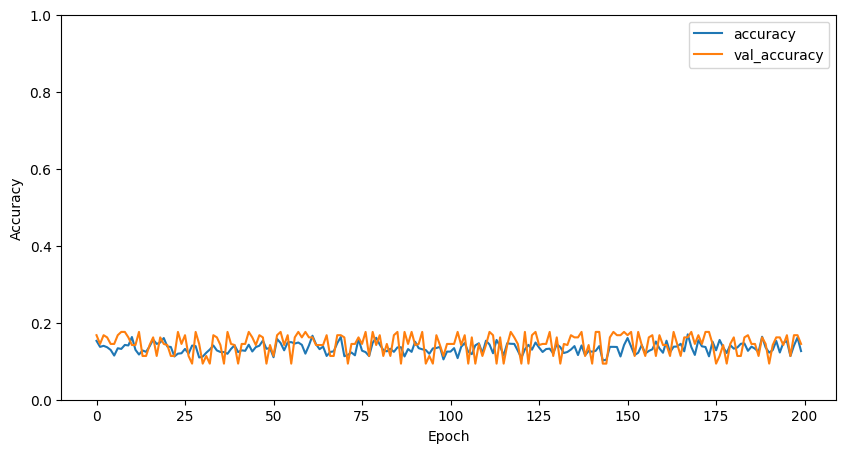

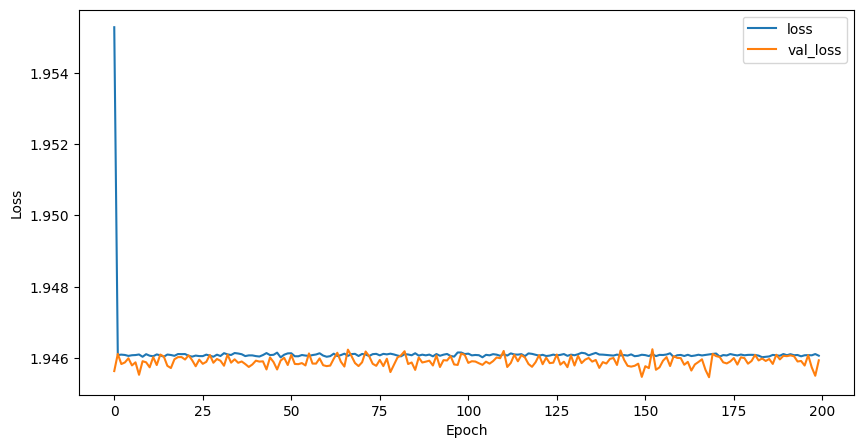

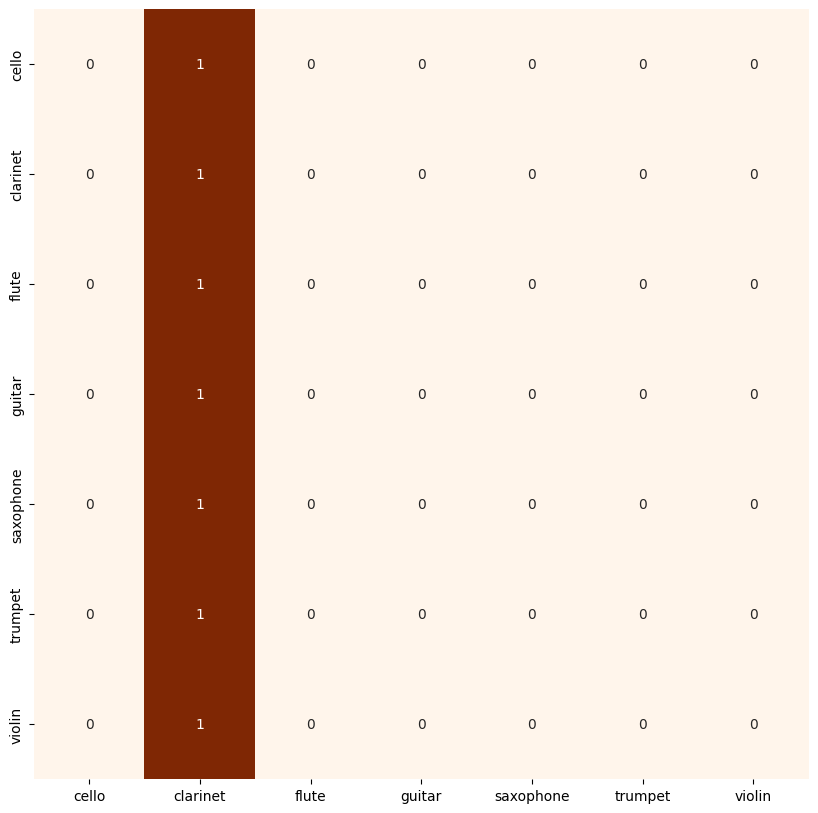

In [23]:
model2.load_weights("results/adam-1e3-conv2/instrument-recognition.weights.h5")
history=np.load('results/adam-1e3-conv2/history.npy',allow_pickle='TRUE').item()
plot_history(history)
results = model2.evaluate(eval_ds)

print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")
print(f"Test AUC: {results[2]}")
print(f"Test F1 Score: {results[3]}")
print(f"Test Precision: {results[4]}")
print(f"Test Recall: {results[5]}")

plot_confusion_matrix(model2, eval_ds, config.label_names)

In [8]:
model3 = keras.Sequential()
model3.add(keras.Input(shape=(config.image_size[0], config.image_size[1], 1)))

# Preprocessing
model3.add(keras.layers.RandomTranslation(0.1, 0.1))
model3.add(keras.layers.RandomBrightness(0.1))
model3.add(keras.layers.RandomContrast(0.1))

# Rescale the pixel values
model3.add(keras.layers.Rescaling(1./255))

# Convolutional layers
model3.add(keras.layers.Conv2D(16,3, padding='same', activation='relu'))
model3.add(keras.layers.MaxPooling2D())
model3.add(keras.layers.Conv2D(32,3, padding='same', activation='relu'))
model3.add(keras.layers.MaxPooling2D())
model3.add(keras.layers.Conv2D(64,3, padding='same', activation='relu'))
model3.add(keras.layers.MaxPooling2D())
model3.add(keras.layers.Dropout(0.2))
model3.add(keras.layers.Flatten())

# Dense Layers
model3.add(keras.layers.Dense(128, activation='relu'))
model3.add(keras.layers.Dense(config.n_classes, activation='softmax'))

model3.compile(optimizer=keras.optimizers.SGD(), 
                     loss='categorical_crossentropy', 
                     metrics=[keras.metrics.CategoricalAccuracy(),
                              keras.metrics.AUC(),
                              keras.metrics.F1Score(), 
                              keras.metrics.Precision(),
                              keras.metrics.Recall()])

model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_translation_2            │ (None, 128, 128, 1)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness_2             │ (None, 128, 128, 1)    │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_2               │ (None, 128, 128, 1)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,121,479 (8.09 MB)

 Trainable params: 2,121,479 (8.09 MB)

 Non-trainable params: 0 (0.00 B)

/Users/mariapolak/miniconda3/envs/mlme/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 11 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - auc_2: 0.8387 - categorical_accuracy: 0.5166 - f1_score: 0.4973 - loss: 1.3971 - precision_2: 0.6212 - recall_2: 0.3695
Test Loss: 1.419866919517517
Test Accuracy: 0.5074257254600525
Test AUC: 0.8327599763870239
Test F1 Score: [0.5348836  0.52173907 0.49382713 0.6805555  0.27368417 0.4861111
 0.48951042]
Test Precision: 0.6188340783119202
Test Recall: 0.34158414602279663
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


2024-12-03 12:59:28.013542: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


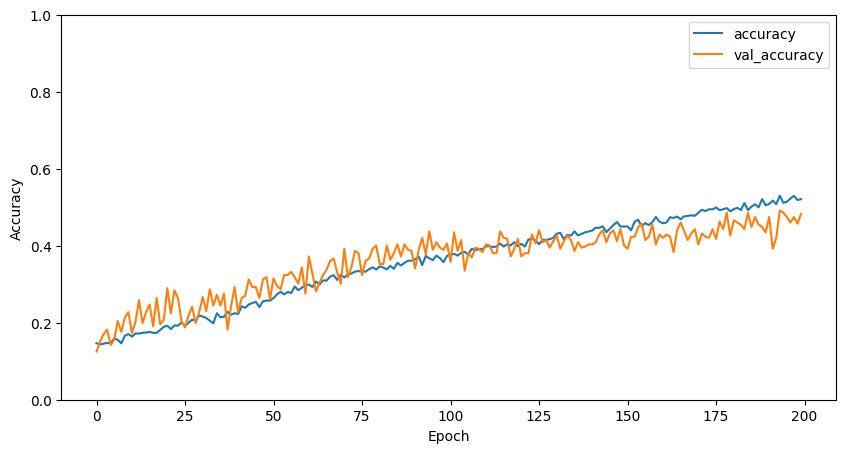

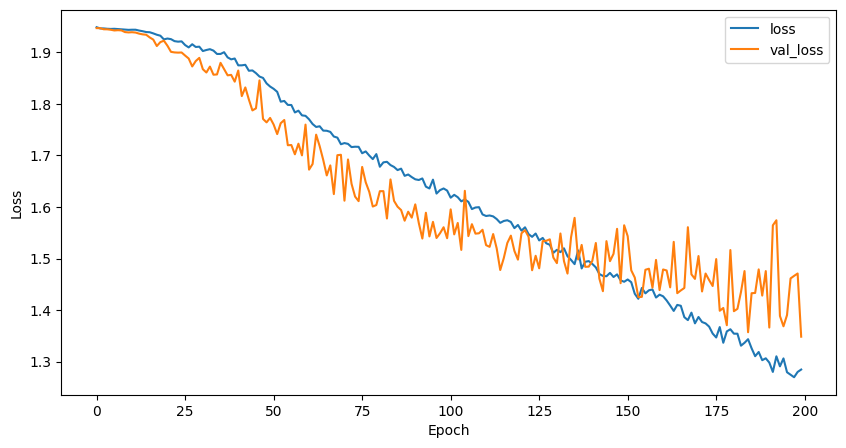

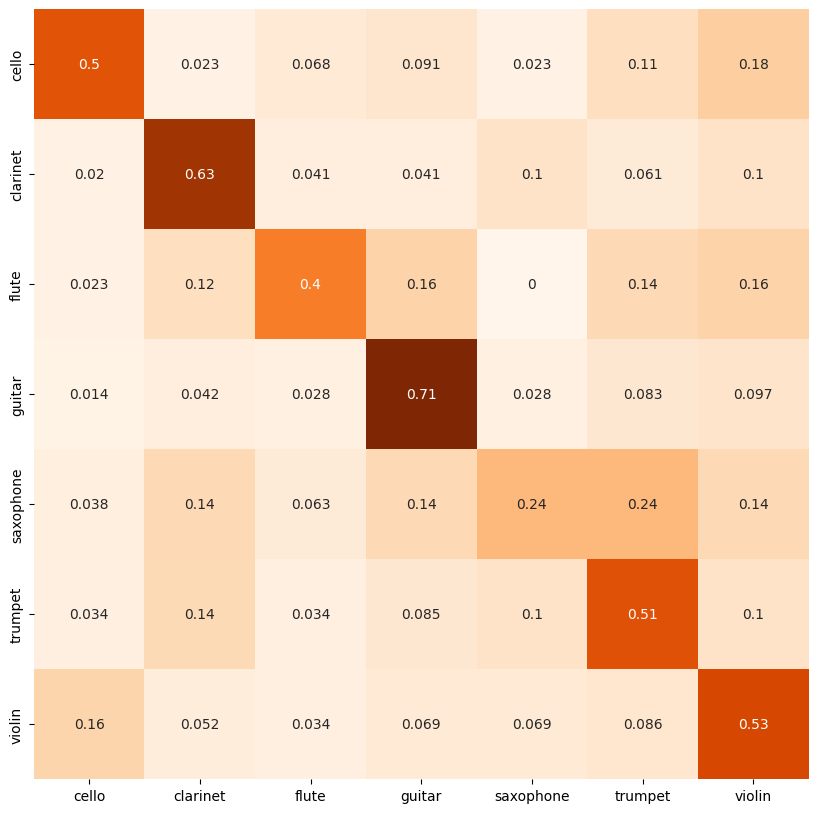

In [24]:
model3.load_weights("results/sgd-1e2-conv1/instrument-recognition.weights.h5")
history=np.load('results/sgd-1e2-conv1/history.npy',allow_pickle='TRUE').item()
plot_history(history)
results = model3.evaluate(eval_ds)

print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")
print(f"Test AUC: {results[2]}")
print(f"Test F1 Score: {results[3]}")
print(f"Test Precision: {results[4]}")
print(f"Test Recall: {results[5]}")

plot_confusion_matrix(model3, eval_ds, config.label_names)

/Users/mariapolak/miniconda3/envs/mlme/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 11 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - auc_2: 0.8580 - categorical_accuracy: 0.5392 - f1_score: 0.5300 - loss: 1.5326 - precision_2: 0.5878 - recall_2: 0.4765
Test Loss: 1.54141104221344
Test Accuracy: 0.5470296740531921
Test AUC: 0.8583815097808838
Test F1 Score: [0.49462363 0.48979586 0.5555555  0.74999994 0.43902436 0.5762711
 0.50632906]
Test Precision: 0.60429447889328
Test Recall: 0.48762375116348267
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2024-12-03 12:59:48.398221: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


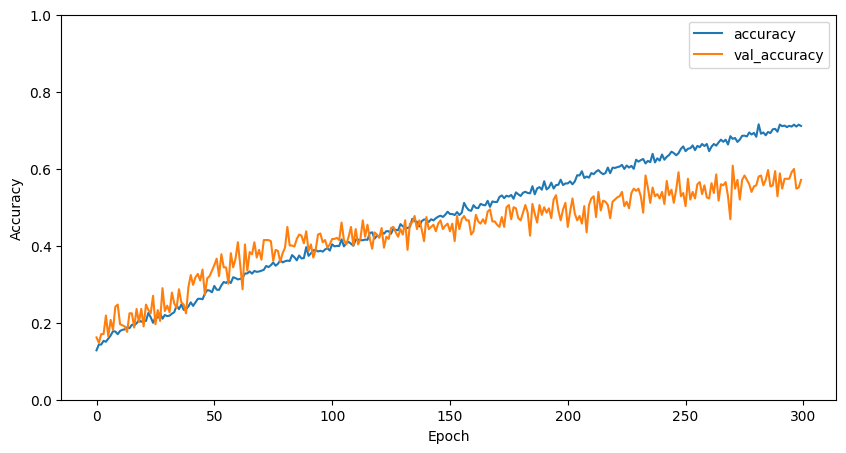

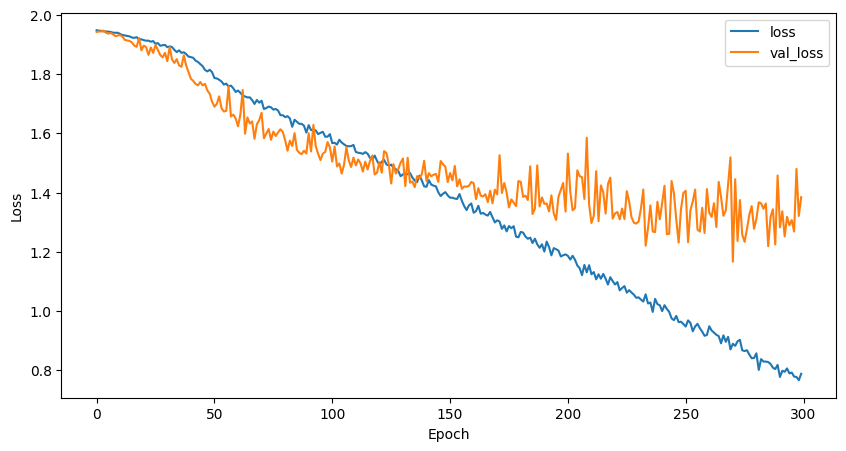

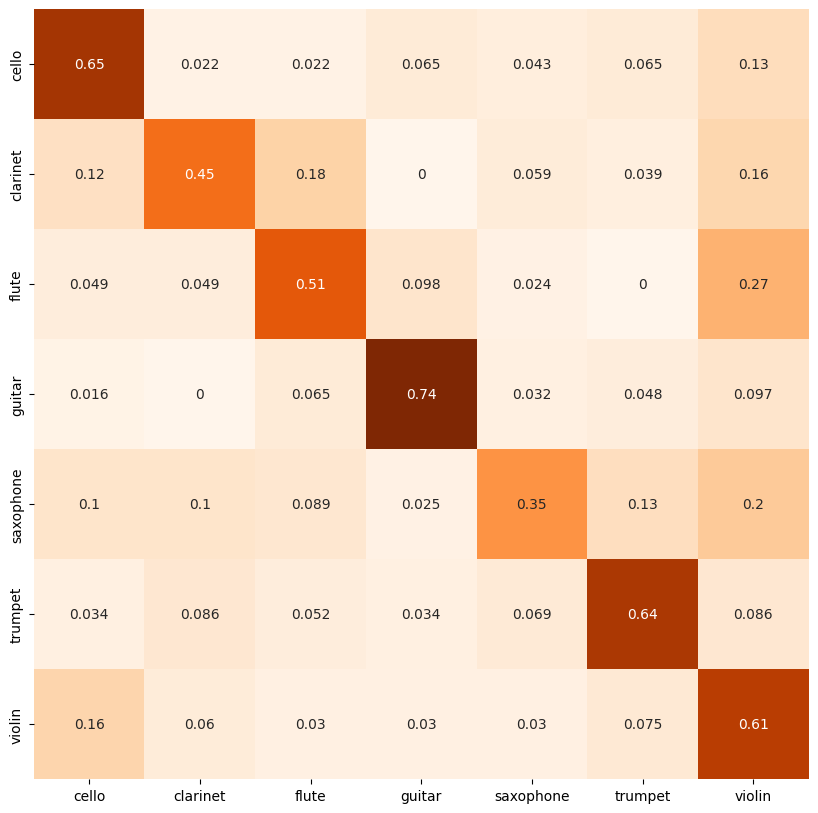

In [25]:
model3.load_weights("results/sgd-1e2-conv1-300e/instrument-recognition.weights.h5")
history=np.load('results/sgd-1e2-conv1-300e/history.npy',allow_pickle='TRUE').item()
plot_history(history)
results = model3.evaluate(eval_ds)

print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")
print(f"Test AUC: {results[2]}")
print(f"Test F1 Score: {results[3]}")
print(f"Test Precision: {results[4]}")
print(f"Test Recall: {results[5]}")

plot_confusion_matrix(model3, eval_ds, config.label_names)

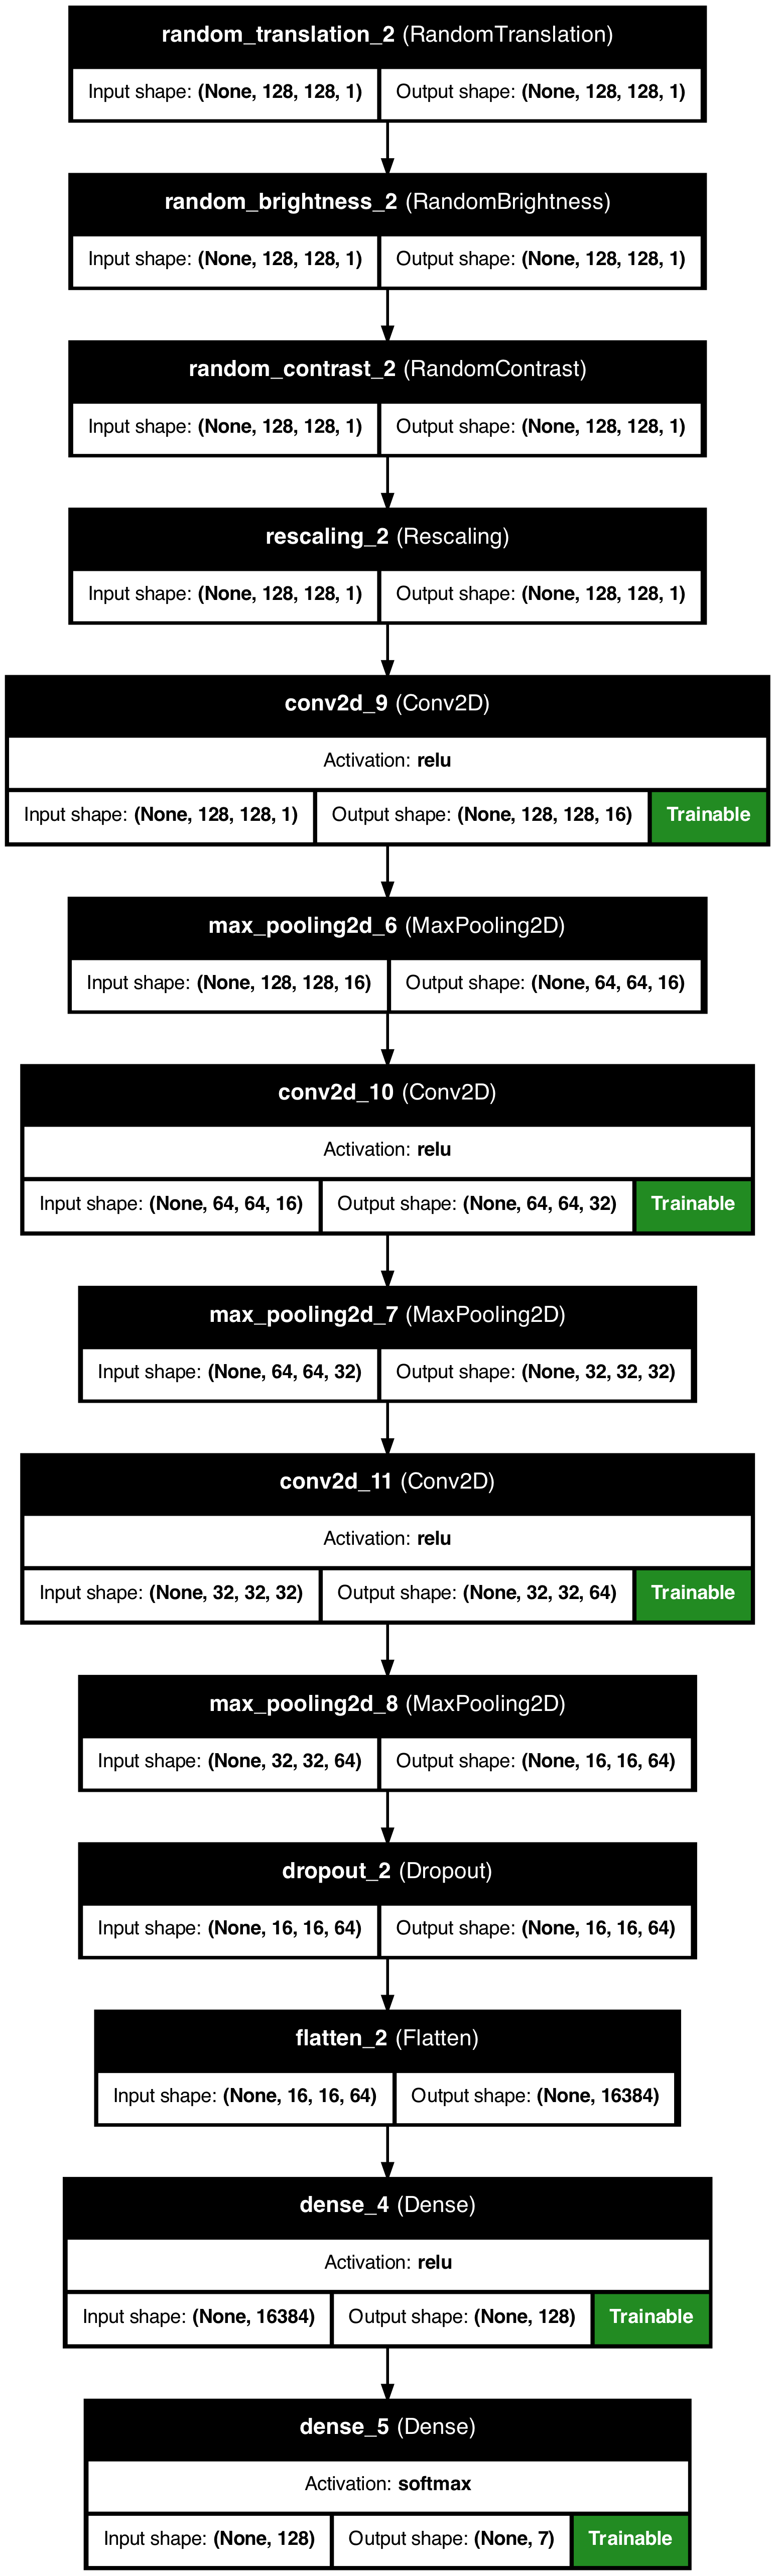

In [18]:
dot_img_file = 'results/sgd-1e2-conv1/model.png'
keras.utils.plot_model(model3, to_file=dot_img_file, rankdir='TB',show_shapes=True, show_layer_names=True, show_layer_activations=True, show_trainable=True)

In [33]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [42]:
import time

# Select 100 samples from the evaluation dataset
samples = train_ds.take(1000)

# Measure the time taken for inference
i = 0 
start_time = time.time()
for batch in samples.as_numpy_iterator():
    imgs, labels = batch
    _ = model.predict(imgs)
    i += 1
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Time taken for model inference on {i} samples: {elapsed_time:.2f} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/

2024-12-03 16:23:37.159131: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
irmas_labels = ["cel", "cla", "flu", "gac", "sax", "tru", "vio"]
label_names = ["cello", "clarinet", "flute", "guitar", "saxophone", "trumpet", "violin"]
n_classes = len(label_names)
data_dir = "datasets/handmade-images"

image_size = (128, 128)
batch_size = 10


full_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed = 123,
    class_names=irmas_labels
)
    